In [1]:
%cd ../src

/home/ubuntu/SPVD_Lightning/src


In [2]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [3]:
from dataloaders.shapenet.shapenet_loader import ShapeNet

categories = ['chair']
path = "../data/ShapeNet"

te = ShapeNet(path, "test", 2048, categories, load_renders=True)

Loading (test) renders for chair (03001627):   0%|          | 0/1317 [00:00<?, ?it/s]

In [4]:
from utils.hyperparams import load_hyperparams

hparams_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/hparams.yaml'

hparams = load_hyperparams(hparams_path)

In [5]:
model_args = {
    'voxel_size' : hparams['voxel_size'],
    'nfs' : hparams['nfs'], 
    'attn_chans' : hparams['attn_chans'], 
    'attn_start' : hparams['attn_start'], 
    'cross_attn_chans' : hparams['cross_attn_chans'], 
    'cross_attn_start' : hparams['cross_attn_start'], 
    'cross_attn_cond_dim' : hparams['cross_attn_cond_dim'],
}

model = SPVUnet(**model_args)
model = GSPVD(model=model)

In [6]:
import numpy as np

samples = 16
references = [te[idx] for idx in np.random.choice(list(range(len(te))), size=(samples,))]

reference_images = torch.stack([r["render-features"] for r in references]).to("cuda")

In [7]:
from utils.helper_functions import process_ckpt
steps = 500
scheduler = 'ddpm'
# ckpt_path = f'../checkpoints/distillation/GSPVD/{"-".join(categories)}/{scheduler}/{steps}-steps.ckpt'
ckpt_path = '/home/ubuntu/SPVD_Lightning/checkpoints/ShapeNet/GSPVD/chair/ddpm/500-steps.ckpt'
ckpt = torch.load(ckpt_path, weights_only=False)
ckpt = process_ckpt(ckpt)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [11]:
model = model.cuda().eval()

In [12]:
from my_schedulers.ddpm_scheduler import DDPMSparseScheduler
from my_schedulers.ddim_scheduler import DDIMSparseScheduler
from utils.visualization import display_pointclouds_grid

if scheduler == 'ddim':
    sched = DDIMSparseScheduler(
        beta_min=hparams['beta_min'], 
        beta_max=hparams['beta_max'], 
        steps=steps, 
        init_steps=hparams['n_steps'],
        mode=hparams['mode'],
    )
else:
    sched = DDPMSparseScheduler(
        beta_min=hparams['beta_min'], 
        beta_max=hparams['beta_max'], 
        steps=steps, 
        init_steps=steps,
        # init_steps=hparams['n_steps'],
        mode=hparams['mode'],
    )

In [13]:
preds = sched.sample(model, samples, 2048, reference=reference_images)
# preds = sched.sample(model, samples, 2048, reference=None)

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
display_pointclouds_grid(preds.cpu().numpy(), offset=8, point_size=0.3)

Output()

In [15]:
real = torch.stack([r["pc"] for r in references]).numpy()
display_pointclouds_grid(real, offset=8, point_size=0.3)

Output()

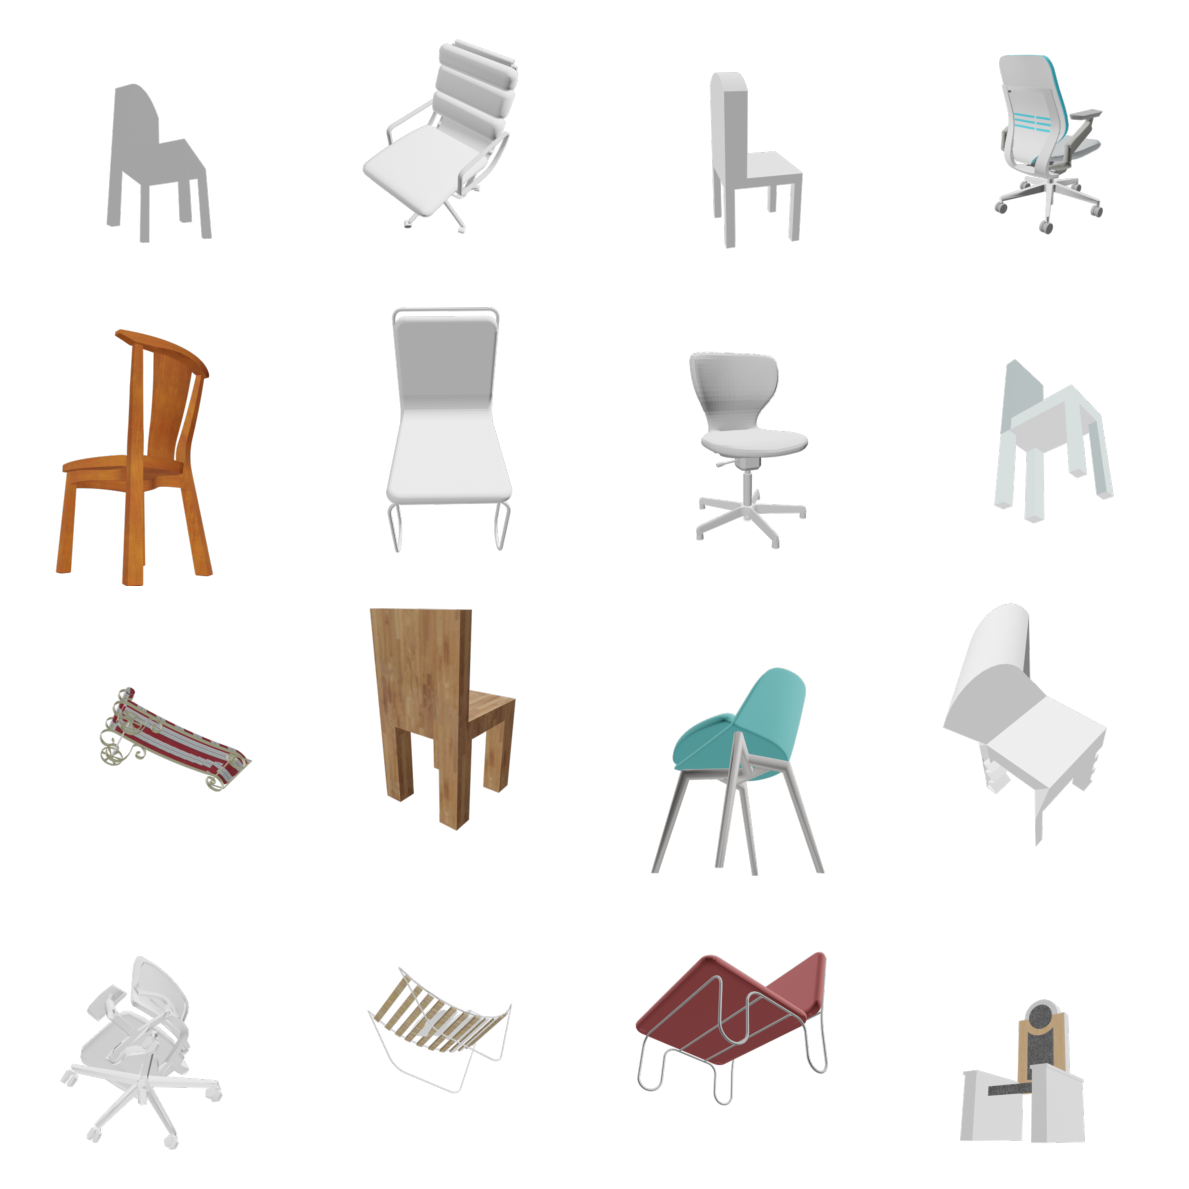

In [16]:
from utils.visualization import display_renders_grid

def load_image(selected_file, selected_view):
    from PIL import Image
    return np.array(Image.open("../data/ShapeNet/renders/" + selected_file + f"/00{selected_view}.png"))

renders = np.stack([load_image(r['filename'], r['selected-view']) for r in references])
display_renders_grid(renders)